# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

__La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.__

In [1]:
#!pip install scikit-surprise

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from surprise import Dataset, Reader
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SVD
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse, fcp
from surprise.model_selection import cross_validate, train_test_split

In [4]:
artist_data = pd.read_csv("/content/drive/My Drive/Recomendación/lastFM/artists.dat", sep="\t")
artist_data.head()
# necesito el id y el artista

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [5]:
user_artist_plays = pd.read_csv("/content/drive/My Drive/Recomendación/lastFM/user_artists.dat", sep="\t")
user_artist_plays.head()
# weight: listening count 

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

* Primero, interesa conocer los tipos de datos y si es que hay valores nulos.

In [6]:
artist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
id            17632 non-null int64
name          17632 non-null object
url           17632 non-null object
pictureURL    17188 non-null object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB


In [7]:
artist_data[artist_data.duplicated()]

,id,name,url,pictureURL


In [8]:
user_artist_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
userID      92834 non-null int64
artistID    92834 non-null int64
weight      92834 non-null int64
dtypes: int64(3)
memory usage: 2.1 MB


In [9]:
user_artist_plays[user_artist_plays.duplicated()]

,userID,artistID,weight


Se observa que dentro de los datos relevantes no hay valores faltantes. Tampoco hay filas duplicadas.

* Luego me pregunto si tengo el nombre de todos los artistas que fueron escuchados.

In [10]:
print('En user_artist_plays: ')
print('   Cantidad de artistas escuchados: ',len(user_artist_plays['artistID'].unique()))
print('   Ids van de ',user_artist_plays['artistID'].min(),' a ',user_artist_plays['artistID'].max())
print('En artist_data:' )
print('   Ids van de ',artist_data['id'].min(),' a ',artist_data['id'].max())

En user_artist_plays: 
   Cantidad de artistas escuchados:  17632
   Ids van de  1  a  18745
En artist_data:
   Ids van de  1  a  18745


In [11]:
False in np.array(artist_data['id'] ) == user_artist_plays.sort_values(by='artistID', ascending=True).artistID.unique()

False

Genial ! No me falta ningún nombre de artista que se haya escuchado.

* Otro punto de interés sería la distribución de los weights (listening count) para ver si hay outliers.

In [12]:
user_artist_plays.weight.describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

Los 614 listenings por usuario acumulan hasta un 75% de los datos. Parece haber unos outliers extremadamente grandes. Se examina mejor:

<Figure size 576x720 with 0 Axes>

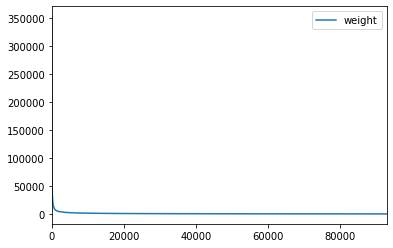

In [13]:
plt.figure(figsize=(8,10))
user_artist_plays.sort_values(by='weight', ascending=False).reset_index(drop=True, inplace=False).plot(y='weight')
plt.show()

Haciendo zoom:

<Figure size 576x720 with 0 Axes>

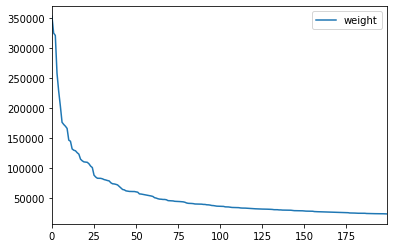

In [14]:
plt.figure(figsize=(8,10))
user_artist_plays.sort_values(by='weight', 
                              ascending=False).reset_index(drop=True,inplace=False)[:200].plot(y='weight')
plt.show()

Ahora dudo que sean outliers, pues todos los valores parecen corresponderse con una distribución.

* ¿Cuáles son los artistas que fueron más escuchados?
Veamos los 15 más escuchados.

In [15]:
num = 15
top_artist = user_artist_plays.groupby(user_artist_plays['artistID'])[['weight']].sum() \
            .sort_values(by='weight', ascending=False).head(num)

top_artist_names = [artist_data[artist_data.id==artist_id].name.tolist()[0] for artist_id in top_artist.index]
top_artist_names

['Britney Spears',
 'Depeche Mode',
 'Lady Gaga',
 'Christina Aguilera',
 'Paramore',
 'Madonna',
 'Rihanna',
 'Shakira',
 'The Beatles',
 'Katy Perry',
 'Avril Lavigne',
 'Taylor Swift',
 'Evanescence',
 'Glee Cast',
 'Beyoncé']

* ¿Cómo es la distribución de cantidad de listens por user?

Primero vemos cuántos usuarios hay.

In [16]:
len(user_artist_plays['userID'].unique())

1892

In [0]:
top_user = user_artist_plays.groupby(user_artist_plays['userID'])[['weight']].sum() \
            .sort_values(by='weight', ascending=False)

<Figure size 576x720 with 0 Axes>

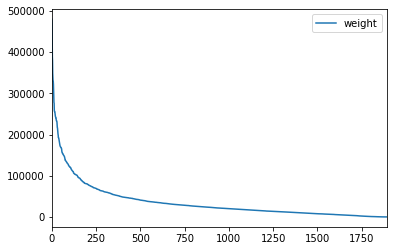

In [18]:
plt.figure(figsize=(8,10))
top_user.sort_values(by='weight', ascending=False).reset_index(drop=True, inplace=False).plot(y='weight')
plt.show()

* ¿Es posible ver el género más escuchado? tags.dat y user_taggedartists.dat

En user_taggedartists.dat tengo los artistas etiquetados por los usuarios. Para conocer el género más escuchado debería ver a qué genero pertenecen los artistas más escuchados. Aún así, la dificultad es que tengo distintos tags para un mismo artista y no todos corresponden a un género musical.

In [19]:
tags_data = pd.read_csv("/content/drive/My Drive/Recomendación/lastFM/tags.dat", sep="\t",  encoding='ISO-8859-1')
tags_data.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [20]:
user_taggedartists_data = pd.read_csv("/content/drive/My Drive/Recomendación/lastFM/user_taggedartists.dat", sep="\t",  encoding='ISO-8859-1')
user_taggedartists_data.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


Como una primera aproximación puedo tomar los 15 artistas más escuchados, y ver qué tags tienen asignados.

In [0]:
top_tags = []
for idd in top_artist.index:
    top_tags.extend(user_taggedartists_data[user_taggedartists_data.artistID==idd].tagID.unique())

frecs_toptags = Counter(top_tags).items() # lista de pares ordenados (tag,frecuencia)
# los ordeno en orden descendente segun la frecuencia:
frecs_toptags = sorted(frecs_toptags, key=lambda x: x[1], reverse=True)
# Vemos los 10 tags más frecuentes
maxtags = frecs_toptags[:10]

In [22]:
for tag,frec in maxtags:
  print(tags_data[tags_data.tagID==tag].tagValue)

23    pop
Name: tagValue, dtype: object
72    rock
Name: tagValue, dtype: object
233    amazing
Name: tagValue, dtype: object
501    love
Name: tagValue, dtype: object
38    dance
Name: tagValue, dtype: object
129    female vocalists
Name: tagValue, dtype: object
357    favorites
Name: tagValue, dtype: object
284    awesome
Name: tagValue, dtype: object
723    love at first listen
Name: tagValue, dtype: object
205    <3
Name: tagValue, dtype: object


Los géneros de los artistas más escuchados son pop y rock. Además, se observa que las tags asignadas a cada artista son demasiadas y la mayoría no son de género.

## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

Armar la matriz usuario-contenido implica pasar los datos de user_artist_plays a una matriz.

In [23]:
user_artist_plays.head(3)

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351


Antes, puedo limitar los weights a 614 que acumula el 75% de los datos, y usar éste valor como el máximo que indica que a un usuario le gustó mucho el artista. Luego, en el otro extremo, si weight es 1 significa que al usuario no le gustó el artista. Si es 0 hay que predecir el puntaje.

In [0]:
def cota_sup(x):
    if x>614:
        return 614
    else:
        return x

user_artist_plays['weight'] = user_artist_plays['weight'].apply(cota_sup)

In [25]:
df_matrix = pd.pivot_table(user_artist_plays, values='weight', index='userID', columns='artistID').fillna(0)
df_matrix.head(10)

artistID,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,34,36,37,38,39,40,41,43,44,45,...,18696,18697,18698,18706,18707,18708,18709,18710,18711,18712,18713,18714,18715,18716,18717,18718,18719,18720,18721,18722,18723,18724,18725,18726,18727,18728,18729,18730,18734,18735,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_matrix.shape

(1892, 17632)

Se ve que la matriz usuario-contenido es muy sparsa. En filas tengo los 1892 usuarios y en columnas los 17632 artistas.

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. 


In [27]:
user_artist_plays.head(3)

,userID,artistID,weight
0,2,51,614
1,2,52,614
2,2,53,614


In [0]:
reader = Reader(rating_scale=(user_artist_plays.weight.min(), user_artist_plays.weight.max()))
plays = Dataset.load_from_df(user_artist_plays[['userID','artistID','weight']], reader)
plays_train, plays_test = train_test_split(plays, test_size=0.2)

In [29]:
results = pd.DataFrame(columns=['Modelo','rmse','fcp']) 
sim_options = {'name': 'cosine'}
for idx,algorithm in enumerate([NormalPredictor(), BaselineOnly(), \
                  KNNBasic(), KNNWithMeans(k=30, verbose=False, sim_options=sim_options), \
                        KNNBaseline(), KNNWithZScore(k=30, verbose=False, sim_options=sim_options), \
                                SVD(), NMF(), SlopeOne(), CoClustering()]):
    model = algorithm
    model.fit(plays_train)
    predictions = model.test(plays_test)
    results.loc[idx] = [str(algorithm).split(' ')[0].split('.')[-1], \
                        rmse(predictions, verbose=False), fcp(predictions, verbose=False)]

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [30]:
results

,Modelo,rmse,fcp
0,NormalPredictor,292.351966,0.495359
1,BaselineOnly,143.539206,0.548996
2,KNNBasic,215.554449,0.504493
3,KNNWithMeans,156.956008,0.516351
4,KNNBaseline,159.534719,0.509807
5,KNNWithZScore,157.079417,0.519245
6,SVD,377.791612,0.000000
7,NMF,365.536815,0.480439
8,SlopeOne,158.152156,0.529494
9,CoClustering,162.811629,0.524531


Se entrenaron los modelos. De ellos, el mejor modelo parece ser BaselineOnly. 

## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.


Para ello se utilizará un modelo de scikit surprise que dado un item, devuelve los items más cercanos (más similares). Se tomará como guía: 
https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-k-nearest-neighbors-of-a-user-or-item

_"You can use the get_neighbors() methods of the algorithm object. This is only relevant for algorithms that use a similarity measure, such as the k-NN algorithms."_ De los knn entrenados el modelo con mejor desempeño parece ser KNNWithMeans. Vamos a hacer una búsqueda de hiperparámetros para ver si mejora.



In [31]:
results = pd.DataFrame(columns=['k','metric','rmse'])
idx = 0
for k in [10,20,30,40]:
    for namesim in ['cosine', 'msd']:
        model = KNNWithMeans(k=k, sim_options= {'name':namesim,'user_based': False}, verbose=False)
        model.fit(plays_train)
        predictions = model.test(plays_test)
        #row = pd.DataFrame({'k':k,'metric':namesim,'rmse':rmse(predictions,verbose=False)})
        results.loc[idx] = [k, namesim, rmse(predictions,verbose=False)]
        idx+=1

print('Modelo KNNWithMeans basado en items.')

Modelo KNNWithMeans basado en items.


In [32]:
results

,k,metric,rmse
0,10,cosine,170.907035
1,10,msd,188.761297
2,20,cosine,168.627066
3,20,msd,188.149462
4,30,cosine,168.230657
5,30,msd,187.896204
6,40,cosine,168.149955
7,40,msd,187.839065


Se ve que con 30 vecinos y distancia coseno el error varía respecto del obtenido antes, ya que ahora se esta usando un filtro colaborativo basado en items. Aún así elegimos usar éstos hiperparámetros pues son los que menos error tienen dentro de los knn item based.

In [33]:
# First, train the algortihm to compute the similarities between items
model = KNNWithMeans(k=30, sim_options={'name':'cosine','user_based': False}, verbose=False)
model.fit(plays_train)

In [0]:
def find_artist_nearest(name):
  # Retrieve id of the artist: Grendel
  artist_name = name
  artist_id = int(artist_data[artist_data.name == artist_name].id.values)

  # Retrieve ids of the nearest neighbors.
  artist_ids_neighbors = model.get_neighbors(artist_id, k=10)

  # Convert ids of the neighbors into names.
  artist_names_neighbors = [artist_data[artist_data.id==ids].name  for ids in artist_ids_neighbors]

  print('The 10 nearest neighbors of ',name,' are:')
  for art in artist_names_neighbors:
      print(art.tolist())

In [35]:
# Select an artist
name = artist_data[artist_data.id== 25 ].name.tolist()[0]
find_artist_nearest(name)

The 10 nearest neighbors of  Cradle of Filth  are:
['MALICE MIZER']
['Carpathian Forest']
['Marilyn Manson']
['Agonoize']
['Covenant']
[]
['Icon of Coil']
[]
['Dawn of Ashes']
['The Faint']


In [36]:
# Select an artist
name = 'Madonna'
find_artist_nearest(name)

The 10 nearest neighbors of  Madonna  are:
[]
['Laibach']
['Emperor']
['Max Richter']
['Part Timer']
['cokiyu']
['יוני בלוך']
['Stereophonics']
['The Killers']
['Wir sind Helden']


In [37]:
# Select an artist
name = artist_data[artist_data.id== 65 ].name.tolist()[0]
find_artist_nearest(name)

The 10 nearest neighbors of  Coldplay  are:
['Bella Morte']
[]
['Psyclon Nine']
['Cradle of Filth']
['Tamtrum']
['Laibach']
['Icon of Coil']
['Sopor Aeternus & The Ensemble of Shadows']
['Duran Duran']
['Kylie Minogue']
